In [1]:
%pylab inline
fontsize = 20
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy.signal import savgol_filter, periodogram
from scipy import interpolate
from scipy.stats import wilcoxon
from numpy.fft import fft, ifft, fftfreq
from time import time
from tqdm import tqdm

from tqdm import trange
from best_subset import *
from solvel0 import solvel0
from pde_diff_new import RPCA
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff
import pynumdiff
import sys; sys.path.insert(0, "../derivative/"); import derivative

from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.preprocessing import normalize as sk_normalize

from findiff import FinDiff
from abess.linear import LinearRegression
from UBIC import fit_blr, UBIC, decreasing_values_indices
from skscope_tools import best_subset_all_solutions, abess_all_solutions

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

def ssr2llf(ssr, nobs, epsilon=1e-5):
    nobs2 = nobs / 2.0
    # llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    llf = -nobs2*np.log(2*np.pi*ssr/nobs+epsilon)
    return llf

def rss2bic(rss, nparams, nobs, epsilon=1e-5):
    # llf = ssr2llf(rss, nobs, epsilon)
    # return -2*llf + np.log(nobs)*nparams
    return nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*nparams

def BIC_Loss(As,bs,x,epsilon=1e-5):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    # Complexity
    k = np.count_nonzero(x)/m
    # BIC
    res = np.vstack([bs[j] - As[j]@x[:, j:j+1] for j in range(m)])
    assert len(res) == n*m
    rss = np.linalg.norm(res, ord='fro')**2
    llf = ssr2llf(rss, N, epsilon)
    # llf = -(N/2)*np.log(2*np.pi*rss/N+epsilon)
    # -2*llf + np.log(N)*k # AIC: -2*llf + 2*k
    # return -2*llf + np.log(N)*k
    return N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*k

np.random.seed(1234)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.4.0


In [2]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv = a*(1+c*np.sin(t))*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u))
    return real(deriv)

In [3]:
# Set size of grid -> affect discovery results
n = 256
m = 256
    
# Set up grid
x = np.linspace(-8,8,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,10,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x+1)**2)

# Solve with time dependent uu_x term
params = (k, -1, 0.1, 0.25)
u = odeint(parametric_burgers_rhs, u0, t, args=(params,)).T # shape = (len(x), len(t))

u_xx_true = 0.1*np.ones(m)
uu_x_true = -1*(1+0.25*np.sin(t))

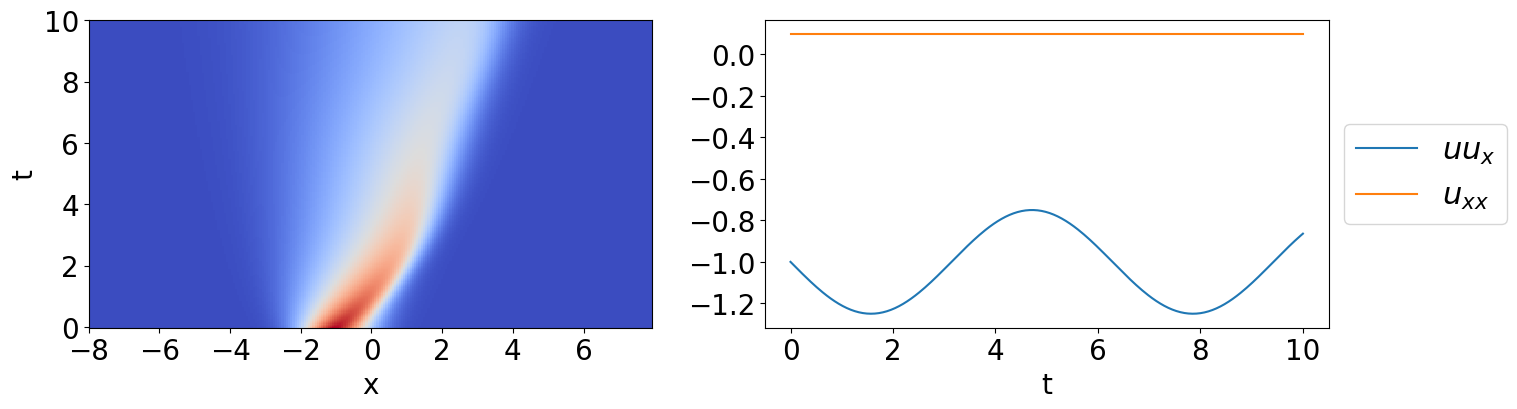

In [4]:
# Plot
fig=figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(t, uu_x_true, label=r'$uu_{x}$')
plot(t, u_xx_true, label=r'$u_{xx}$')

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('t', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [5]:
noise_lv = 1
noise_lv = abs(noise_lv)
u = u + 0.01*noise_lv*std(u)*np.random.randn(n, m)

In [6]:
include_bias = False
is_denoising = True

if is_denoising:
    window_size = 15
    poly_order = 2
    # equivalent to np.hstack([savgol_filter(u[:, i], window_size, poly_order).reshape(-1, 1) for i in range(u.shape[-1])])
    u = savgol_filter(u, window_size, poly_order, axis=1)

if abs(noise_lv) > 0:
    print("Noisy", abs(noise_lv))
    # Build linear systems
    wx = 10
    wt = 10

    Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'poly', 
                                               deg_x = 6, deg_t = 4, 
                                               width_x = wx, width_t = wt)
    n = n - 2*wx
    m = m - 2*wt
    rhs_des = np.array(rhs_des)
    
else:
    print("Noiseless")
    Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'FD')
    rhs_des = np.array(rhs_des)
    
if not include_bias:
    Theta = Theta[:, 1:]
    rhs_des = np.array(rhs_des)[1:]
    

Noisy 1


In [7]:
def spatial_temporal_group(Theta, Ut, domain_shape, dependent="temporal"):
    n, m = domain_shape
    assert n*m == Theta.shape[0], Ut.shape[0]
    if dependent == "temporal":
        Theta_grouped = [(Theta[j*n:(j+1)*n,:]).real for j in range(m)]
        Ut_grouped = [(Ut[j*n:(j+1)*n]).real for j in range(m)]
    elif dependent == "spatial":
        Theta_grouped = [(Theta[n*np.arange(m)+j,:]).real for j in range(n)]
        Ut_grouped = [(Ut[n*np.arange(m)+j]).real for j in range(n)]
    else: return
    return Theta_grouped, Ut_grouped

def normalize_groups(As, bs, normalize=2):
    m = len(As)
    n,D = As[0].shape
    
    # get norm of each column
    candidate_norms = np.zeros(D)
    for i in range(D):
        candidate_norms[i] = Norm(np.vstack([A[:,i] for A in As]), normalize)

    norm_bs = [m*Norm(b, normalize) for b in bs]

    normalized_As = As.copy()
    normalized_bs = bs.copy()
    # normalize
    for i in range(m):
        normalized_As[i] = normalized_As[i].dot(np.diag(candidate_norms**-1))
        normalized_bs[i] = normalized_bs[i]/norm_bs[i]
        
    return normalized_As, normalized_bs

def remove_f(uu, percent):
    if percent <= 0: return uu
    PSD = (uu*np.conj(uu))/np.prod(uu.shape)
    PSD = PSD.real
    mask = (PSD>np.percentile(PSD, percent)).astype(np.float32)
    return uu*mask

In [8]:
Theta_grouped = np.array([real(Theta[j*n:(j+1)*n,:]) for j in range(m)])
Ut_grouped = np.array([real(Ut[j*n:(j+1)*n]) for j in range(m)])
fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(Theta_grouped.shape[-1])])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

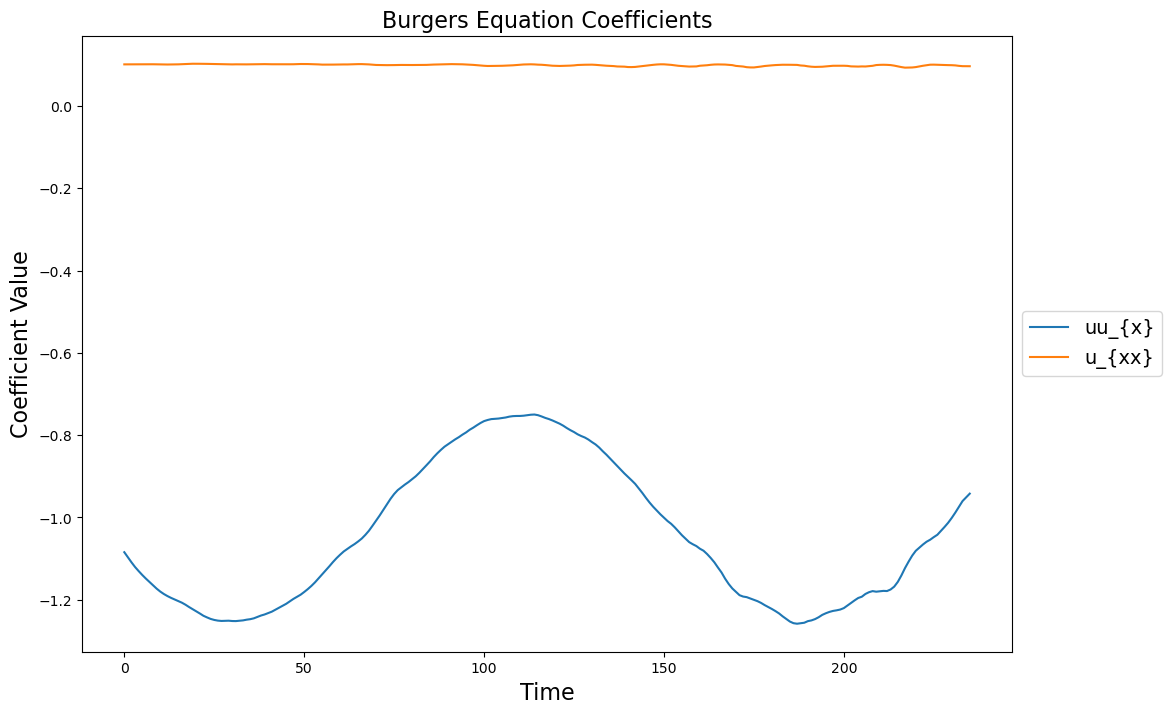

In [9]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped, normalize=2)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in np.where(np.linalg.norm(xi, axis=-1) > 1e-10)[0]:
    plot(xi[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

In [10]:
candidates = set()
max_complexity = 10 # X_weak.shape[-1]

normalized_Theta_grouped, normalized_Ut_grouped = normalize_groups(Theta_grouped, 
                                                                   Ut_grouped, 
                                                                   2)

counter = {0}; i = 0
max_counter = 30
while True:
    bs_i = solvel0(normalized_Theta_grouped[i], 
                   normalized_Ut_grouped[i], 
                   max_complexity=max_complexity, 
                   miosr=True, refine=True, verbose=False)
    
#     bs_i = best_subset_all_solutions(normalized_Theta_grouped[i], 
#                                      normalized_Ut_grouped[i], 
#                                      sparsity=max_complexity, 
#                                      refine=True)[1]
    
#     bs_i = abess_all_solutions(normalized_Theta_grouped[i], 
#                                      normalized_Ut_grouped[i], 
#                                      sparsity=max_complexity, 
#                                      refine=True)[1]
    
    bs_i = list(map(tuple, bs_i))
    candidates = candidates.union(bs_i)
    
    if len(counter) == max_counter: break
        
    print(len(counter))
    i = np.random.choice(len(Theta_grouped))
    while i in counter:
        i = np.random.choice(len(Theta_grouped))
    counter.add(i)

candidates

Set parameter Username


2024-02-11 22:22:23,415 [INFO] Set parameter Username


Academic license - for non-commercial use only - expires 2024-06-04


2024-02-11 22:22:23,418 [INFO] Academic license - for non-commercial use only - expires 2024-06-04


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


{(0, 1, 2, 3, 4, 7, 8, 9, 12, 15),
 (0, 1, 3, 4, 5, 7, 10, 12, 14, 15),
 (0, 1, 3, 4, 5, 7, 12, 13, 15),
 (0, 1, 3, 4, 5, 7, 12, 15),
 (0, 1, 3, 4, 6, 7, 8, 13, 14, 15),
 (0, 1, 3, 4, 6, 7, 9, 13, 14, 15),
 (0, 1, 3, 4, 6, 7, 12, 15),
 (0, 1, 3, 4, 6, 7, 12, 15, 16),
 (0, 1, 3, 4, 6, 7, 13, 14, 15),
 (0, 1, 4, 5, 6, 7, 8, 10, 15, 16),
 (0, 1, 4, 5, 6, 7, 8, 15, 16),
 (0, 1, 4, 5, 6, 7, 9, 15),
 (0, 1, 4, 5, 6, 7, 9, 15, 18),
 (0, 1, 4, 5, 6, 7, 13, 15, 16),
 (0, 1, 4, 5, 7, 8, 13, 14, 15),
 (0, 1, 4, 5, 7, 11, 12, 14, 15),
 (0, 1, 4, 5, 7, 11, 12, 15),
 (0, 1, 4, 5, 7, 12, 15),
 (0, 1, 4, 5, 7, 13, 14, 15),
 (0, 1, 4, 7, 8, 12, 15, 16),
 (0, 2, 3, 4, 5, 7, 9, 12, 14, 15),
 (0, 2, 3, 4, 5, 7, 12, 14, 15),
 (0, 2, 3, 4, 5, 7, 12, 15),
 (0, 2, 3, 4, 6, 7, 9, 12, 14, 15),
 (0, 2, 3, 4, 6, 7, 10, 11, 15, 18),
 (0, 2, 3, 4, 6, 7, 10, 12, 13, 15),
 (0, 2, 3, 4, 6, 7, 12, 14, 15, 17),
 (0, 2, 3, 4, 6, 7, 12, 15),
 (0, 2, 3, 4, 6, 7, 12, 15, 17),
 (0, 2, 3, 4, 6, 7, 12, 15, 17, 18),
 (0, 2, 3, 

In [11]:
lam = 0
for j in range(len(Ut_grouped)):
    est_xi = Ridge(alpha=0, fit_intercept=False).fit(Theta_grouped[j], Ut_grouped[j]).coef_.reshape(-1, 1)
    difference = Ut_grouped[j] - Theta_grouped[j].dot(est_xi)
    lam += (np.linalg.norm(difference, 2)**2)/(np.linalg.norm(est_xi, 2)**2)
lam /= len(Ut_grouped)
print("lam:", lam)

track = {}
for indices in tqdm(candidates):
    com = len(indices)
    rss = 0
    for j in range(len(Ut_grouped)):
        est_xi = Ridge(alpha=lam, fit_intercept=False).fit(Theta_grouped[j][:, indices], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = fft_Ut_grouped[j] - fft_Theta_grouped[j][:, indices].dot(est_xi)
        rss += np.linalg.norm(difference, 2)**2 + lam*np.linalg.norm(est_xi, 2)**2
    if com not in track or track[com][1] > rss:
        track[com] = indices, rss

candidates = set([e[0] for e in list(track.values())])
candidates

lam: 0.00010238819559018712


100%|█████████████████████████████████████████████████████████████████████████████████████████| 154/154 [00:25<00:00,  5.93it/s]


{(0, 1, 2, 3, 4, 7, 8, 9, 12, 15),
 (0, 1, 3, 4, 6, 7, 12, 15),
 (0, 1, 3, 4, 6, 7, 12, 15, 16),
 (3,),
 (3, 4, 7, 14, 15, 16, 18),
 (4, 5, 7, 8, 13, 15),
 (4, 7),
 (4, 7, 8, 13, 15),
 (4, 7, 11),
 (4, 7, 12, 16)}

aic: 10
bic: 10


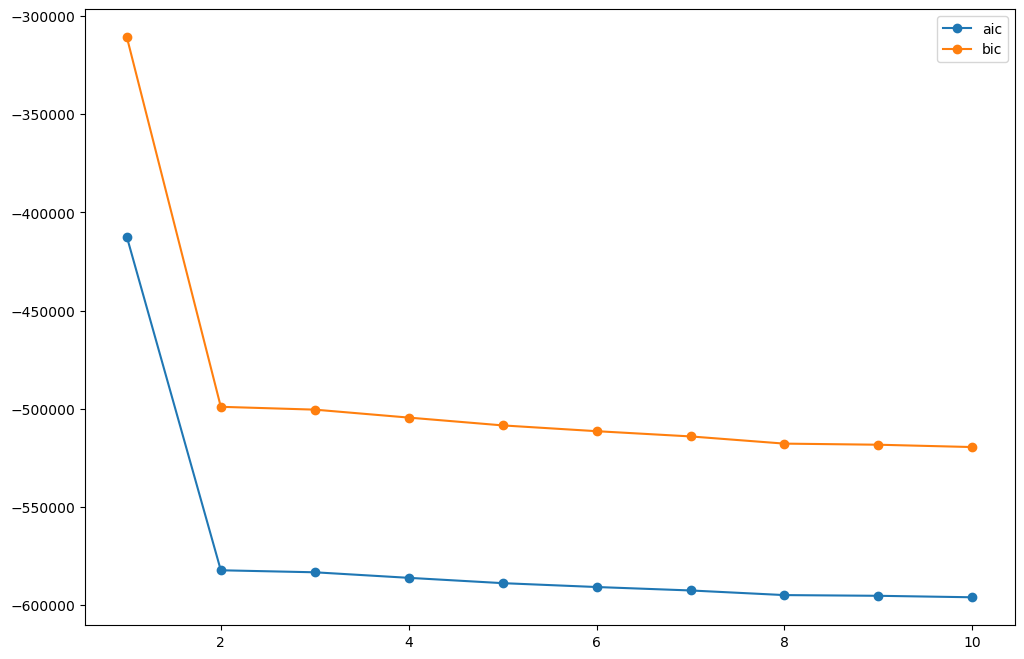

In [12]:
ic_scores = {}
for indices in candidates:
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    for j in range(len(Theta_grouped)):
        est_xi[indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, indices], Ut_grouped[j], rcond=None)[0]
    aic = PDE_FIND_Loss(Theta_grouped, Ut_grouped, est_xi)
    bic = BIC_Loss(Theta_grouped, Ut_grouped, est_xi)
    if len(indices) not in ic_scores: ic_scores[len(indices)] = (aic, bic, indices)
    elif aic < ic_scores[len(indices)][0]: ic_scores[len(indices)] = (aic, bic, indices)

com_ics = sorted([(len(e[2]), e[0], e[1]) for e in list(ic_scores.values())])
complexities = [e[0] for e in com_ics]
aics = [e[1] for e in com_ics]
bics = [e[2] for e in com_ics]

print("aic:", complexities[np.argmin(aics)])
print("bic:", complexities[np.argmin(bics)])
plt.plot(complexities, aics, '-o', label='aic')
plt.plot(complexities, bics, '-o', label='bic'); plt.legend(); plt.show()

In [13]:
best_subsets = {}
for indices in candidates:
    est_xi = []
    uncert = 0.0
    rss = 0.0
    for j in trange(0, len(Theta_grouped), 1):        
        # model = Ridge(alpha=lam, fit_intercept=False)
        model = BayesianRidge(fit_intercept=False)
        model.fit(Theta_grouped[j][:, indices], Ut_grouped[j].flatten())
        post_prediction = (fft_Theta_grouped[j][:, indices]@model.coef_).reshape(-1, 1)
        rss = rss + np.linalg.norm(fft_Ut_grouped[j] - post_prediction, 'fro')**2
        
        coeff = model.coef_.reshape(-1, 1)
        uncert = uncert + np.sqrt(np.diag(model.sigma_)).sum()/abs(model.coef_).sum()
        est_xi.append(coeff)
        
    if len(indices) not in best_subsets: best_subsets[len(indices)] = (rss, uncert, indices)
    elif rss < best_subsets[len(indices)][0]: best_subsets[len(indices)] = (rss, uncert, indices)

100%|███████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 1070.97it/s]


In [14]:
# nobs = Theta_grouped[0].shape[0]*len(Ut_grouped)
# min_uncert = np.min([best_subsets[com][1] for com in best_subsets])
# epsilon = max(1e-5, np.max([2*np.pi*best_subsets[com][0]/nobs for com in best_subsets]))
# epsilon = 1e-5
# print("epsilon", epsilon)
# complexities = sorted(best_subsets.keys())
# bics = []
# uncertainties = []
# for com in complexities:
#     rss, uncert, indices = best_subsets[com]
#     uncert = uncert/min_uncert
#     uncertainties.append(uncert)
#     bics.append(rss2bic(rss, com, nobs, epsilon))
# uncertainties = np.array(uncertainties)
# best_indices = best_subsets[complexities[np.argmin(bics)]][-1]
# print(complexities[np.argmin(bics)])
# print(best_indices)
# plt.plot(complexities, bics, '-o'); plt.show()

#### in PSD space

In [15]:
complexities = sorted(best_subsets.keys())

min_uncert = np.min([best_subsets[com][1] for com in best_subsets])
uncertainties = []
for com in complexities:
    _, uncert, _ = best_subsets[com]
    uncert = uncert/min_uncert
    uncertainties.append(uncert)
uncertainties = np.array(uncertainties)

nfft = max(fft_Ut_grouped[:, :, 0].shape)
nfft = None
ground_periogram = periodogram(ifft(fft_Ut_grouped[:, :, 0]), nfft=nfft)[-1]
nobs = np.prod(ground_periogram.shape)
epsilons = []
for com in complexities:
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    eff_indices = best_subsets[com][-1]
    for j in range(len(Theta_grouped)):
        est_xi[eff_indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, eff_indices], 
                                                     Ut_grouped[j], 
                                                     rcond=None)[0]
    pred_group = ifft(prediction_group(fft_Theta_grouped, est_xi))
    pred_periogram = periodogram(pred_group, nfft=nfft)[-1]

    res = np.vstack([ground_periogram[j]-pred_periogram[j] for j in range(len(Theta_grouped))])
    rss = np.linalg.norm(res, ord='fro')**2
    epsilons.append(2*np.pi*rss/nobs)
epsilon = max(epsilons)
epsilon

0.0009698765056907014

4


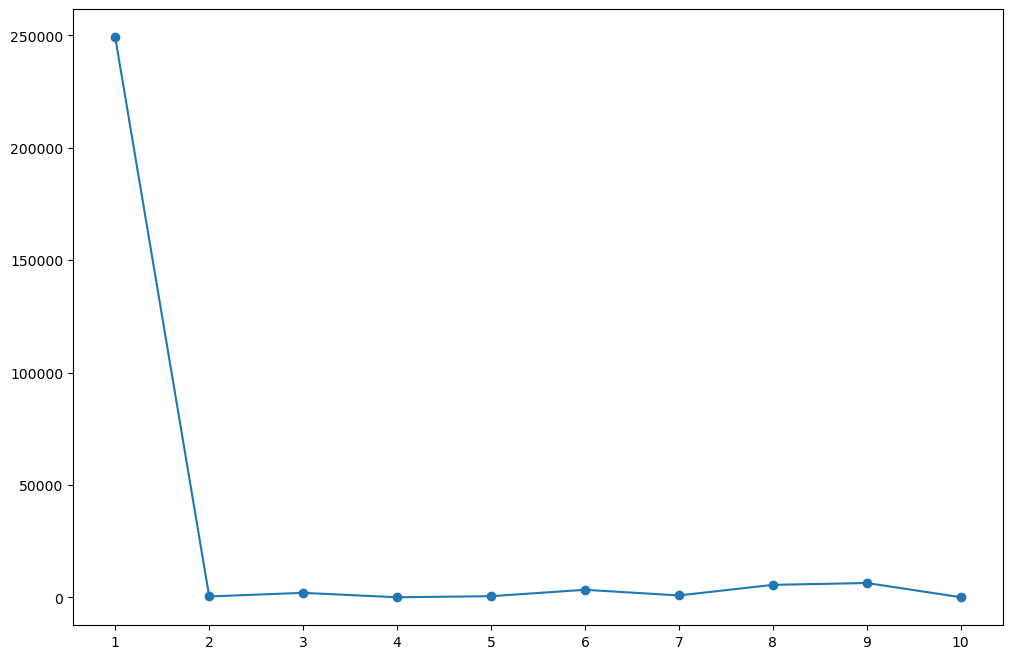

In [16]:
epsilon = 1e-5
ics = []
rss_list = []
varying_bics = []
for com in complexities:
    vbics = []
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    eff_indices = best_subsets[com][-1]
    for j in range(len(Theta_grouped)):
        est_xi[eff_indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, eff_indices], 
                                                     Ut_grouped[j], 
                                                     rcond=None)[0]
        post_prediction = fft_Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
        post_prediction = periodogram(ifft(post_prediction.flatten()))[-1]
        ground = periodogram(ifft(fft_Ut_grouped[j].flatten()))[-1]
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        vbics.append(rss2bic(rss, com, len(post_prediction), 1e-5))
        
    pred_group = ifft(prediction_group(fft_Theta_grouped, est_xi))
    pred_periogram = periodogram(pred_group, nfft=nfft)[-1]

    res = np.vstack([ground_periogram[j]-pred_periogram[j] for j in range(len(Theta_grouped))])
    rss = np.linalg.norm(res, ord='fro')**2
    ics.append(nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*com)
    rss_list.append(rss)
    varying_bics.append(vbics)
    
varying_bics = np.array(varying_bics)
print(np.argmin(ics)+1)
plt.plot(complexities, ics-min(ics), '-o')
plt.xticks(complexities)
plt.show()

#### With tuned UBIC

In [17]:
verbose = True
tau = 3
b_bics = []
lower_bounds = []
for com in complexities:
    _, _, indices = best_subsets[com]
    rss = rss_list[com-1]
    assert com == len(indices)
    lower_bound = 2*np.abs(ssr2llf(rss, nobs))/np.log(nobs)-com
    lower_bounds.append(lower_bound)
    b_bics.append(rss2bic(rss, com, nobs, epsilon))
    
last_lam = np.log10(max(max(lower_bounds/uncertainties), 1e-8))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**last_lam)
last_bc = np.argmin(last_ubic)

thres = 1e-4
percent = 75 # 75 # 90 (เพราะไม่เอา complexity = 1)
b_bics = np.array(b_bics)
complexities = np.array(complexities)
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = max(thres, np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), percent))
pcut = 0.01

while now_lam >= 0:
    now_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**now_lam)
    now_bc = np.argmin(now_ubic)

    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    diff_vbic = varying_bics[now_bc]-varying_bics[last_bc]

    imp = np.nan
    pvalue = np.nan
    if np.abs(diff_com) > 0:
        # imp < thres <--> pvalue > pcut
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
        pvalue = wilcoxon(diff_vbic, alternative='less').pvalue

    # old version using threshold
#     if verbose:
#         print(last_bc, '--->', now_bc, np.nan_to_num(imp, nan=np.inf))
#     if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
#         (diff_com < 0 and diff_bic > 0 and imp > thres):
#         break
    # new version using wilcoxon test
    if verbose:
        print(last_bc, '--->', now_bc, np.nan_to_num(pvalue, nan=np.inf))
    if (diff_com > 0 and (diff_bic > 0 or pvalue > pcut)) or \
        (diff_com < 0 and diff_bic > 0 and pvalue <= pcut):
        break

    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    now_lam = round(now_lam, 8)
    
last_lam = abs(round(last_lam, 8))
best_indices = best_subsets[complexities[last_bc]][-1]; print(best_indices, "selected")
last_lam, last_ubic, last_bc

1 ---> 1 inf
1 ---> 3 1.0
(4, 7) selected


(3.17601177,
 array([-331003.95328576, -618277.11684242, -611989.5743322 ,
        -609297.15559848, -581760.89265241, -434871.83516672,
        -529374.3274943 , -281595.64894717, -211795.95262759,
          89288.98241163]),
 1)

#### Verification process

In [18]:
varying_bics = []
pvalues = [0.0]
for indices in sorted(candidates, key=len):
    vbics = []
    for j in range(0, len(Theta_grouped), 1):
        model = BayesianRidge(fit_intercept=False)
        model.fit(Theta_grouped[j][:, indices], Ut_grouped[j])
        post_prediction = (fft_Theta_grouped[j][:, indices]@model.coef_).reshape(-1, 1)
        # periodogram calculation like weak formulation
        post_prediction = periodogram(ifft(post_prediction.flatten()))[-1]
        ground = periodogram(ifft(fft_Ut_grouped[j].flatten()))[-1]
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        vbics.append(rss2bic(rss, com, len(post_prediction), 1e-5))
    pvalue = np.nan
    if len(varying_bics) > 0:
        wres = wilcoxon(vbics, varying_bics[-1], alternative='less')
        pvalue = wres.pvalue
        pvalues.append(pvalue)
    varying_bics.append(vbics)
    print(indices, pvalue)
    
varying_bics = np.array(varying_bics)
# summ_bics = varying_bics.sum(axis=-1)
# assert len(summ_bics) == len(pvalues)

(3,) nan
(4, 7) 9.072568323615174e-41
(4, 7, 11) 1.0
(4, 7, 12, 16) 4.943611045974993e-16
(4, 7, 8, 13, 15) 0.9711680664070865
(4, 5, 7, 8, 13, 15) 0.9919126860308664
(3, 4, 7, 14, 15, 16, 18) 1.0546305537662346e-26
(0, 1, 3, 4, 6, 7, 12, 15) 0.9972113229891545
(0, 1, 3, 4, 6, 7, 12, 15, 16) 0.0008918844953777007
(0, 1, 2, 3, 4, 7, 8, 9, 12, 15) 1.0399690615621857e-17


In [19]:
pcut = 0.01
min_bic = np.inf
j = None
for i, pvalue in enumerate(pvalues):
    if i == 0: pvalue = 0.0
    else: pvalue = wilcoxon(varying_bics[i]-varying_bics[j], alternative='less').pvalue
    if ics[i] < min_bic and pvalue < pcut:
        min_bic = ics[i]
        j = i
        if pvalue < pcut: 
            print(i+1)

1
2
10
